In [ ]:
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42)

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 labels of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 labels of y: [1 1 1 1 0]


In [ ]:
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


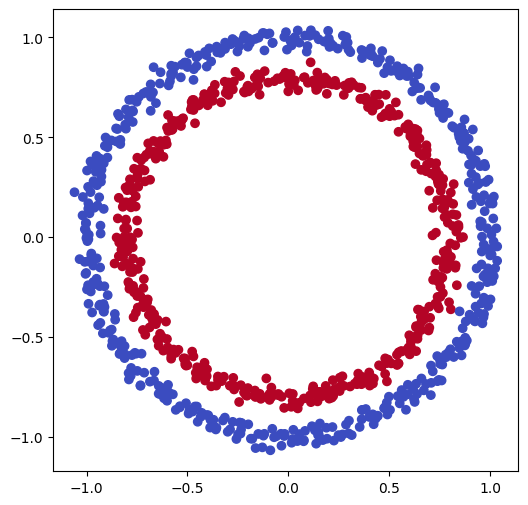

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm);

### 1.1 Check input and output shapes!

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build a model
1. Setup device agnositic code
2. Construct model by subclassing nn.Module
3. Define a loss function and optimizer
4. Create a training and test loop

In [ ]:
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### `nn.Linear` in PyTorch

- `@` means **dot product** (matrix multiplication)

#### Layer components:
- `weight.shape` → `(out_features, in_features)`
- `bias.shape` → `(out_features,)`

#### Matrix multiplication:
`Input @ Weight.T = Output`

`(batch_size, in_features) @ (in_features, out_features) → (batch_size, out_features)

markdown
Copy
Edit
`

#### Notes:
- Input to `nn.Linear(in, out)` must have shape `(batch_size, in)`
- PyTorch automatically transposes the weight matrix for correct multiplication


In [ ]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    """
    self.layer_1 is an instance of nn.Linear, which implements __call__()
    Calling self.layer_1(x) internally runs self.layer_1.forward(x)
    This performs x @ weight.T + bias using learned parameters

    """

    # Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
device

'cpu'

In [ ]:
next(model_0.parameters()).device

device(type='cpu')

In [ ]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [ ]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test sameples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test sameples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]])

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

In [ ]:
loss_fn = nn.BCEWithLogitsLoss() # built in sigmoid activation function

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## 3 Going from raw logits to prediction labels

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# Use the sigmoid activation function on model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

In [ ]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()



tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

### 3.2 Building a training and test loop

In [ ]:
torch.manual_seed(42)

epochs = 100
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train() # puts the model into training mode in PyTorch

  # Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate loss
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Back Propagation
  loss.backward()

  # Gradient descent
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69796, Acc: 51.88% | Test Loss: 0.69440, Test Acc: 58.00%
Epoch: 10 | Loss: 0.69590, Acc: 51.25% | Test Loss: 0.69305, Test Acc: 53.00%
Epoch: 20 | Loss: 0.69490, Acc: 51.62% | Test Loss: 0.69254, Test Acc: 49.50%
Epoch: 30 | Loss: 0.69435, Acc: 51.12% | Test Loss: 0.69236, Test Acc: 49.50%
Epoch: 40 | Loss: 0.69401, Acc: 50.88% | Test Loss: 0.69232, Test Acc: 51.00%
Epoch: 50 | Loss: 0.69378, Acc: 50.25% | Test Loss: 0.69234, Test Acc: 50.00%
Epoch: 60 | Loss: 0.69362, Acc: 50.00% | Test Loss: 0.69239, Test Acc: 51.50%
Epoch: 70 | Loss: 0.69351, Acc: 50.25% | Test Loss: 0.69246, Test Acc: 51.00%
Epoch: 80 | Loss: 0.69342, Acc: 49.88% | Test Loss: 0.69254, Test Acc: 50.00%
Epoch: 90 | Loss: 0.69336, Acc: 49.88% | Test Loss: 0.69262, Test Acc: 53.00%


## 4. Make predictions and evaluate Model

From the metrics it looks like model is guessing

To inspect it we should visualize the predictions.

To do so, we are going to import a function called `plot_decision_boundary()`

In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists


In [ ]:
from helper_functions import plot_predictions, plot_decision_boundary

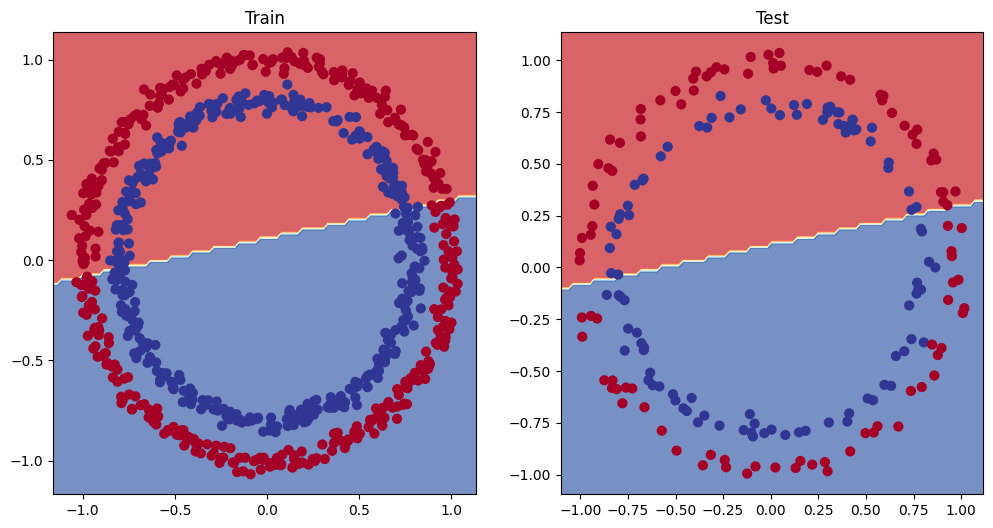

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model

* Add more layers
* Add more hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Create loss function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.001)

In [ ]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 100 | Loss: 0.69392, Acc: 50.50% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 200 | Loss: 0.69389, Acc: 50.62% | Test Loss: 0.69262, Test Acc: 50.50%
Epoch: 300 | Loss: 0.69386, Acc: 50.62% | Test Loss: 0.69263, Test Acc: 50.50%
Epoch: 400 | Loss: 0.69383, Acc: 50.62% | Test Loss: 0.69263, Test Acc: 51.00%
Epoch: 500 | Loss: 0.69381, Acc: 50.75% | Test Loss: 0.69264, Test Acc: 50.50%
Epoch: 600 | Loss: 0.69378, Acc: 50.62% | Test Loss: 0.69265, Test Acc: 51.00%
Epoch: 700 | Loss: 0.69376, Acc: 50.25% | Test Loss: 0.69266, Test Acc: 51.00%
Epoch: 800 | Loss: 0.69373, Acc: 50.00% | Test Loss: 0.69267, Test Acc: 50.50%
Epoch: 900 | Loss: 0.69371, Acc: 49.88% | Test Loss: 0.69268, Test Acc: 50.50%


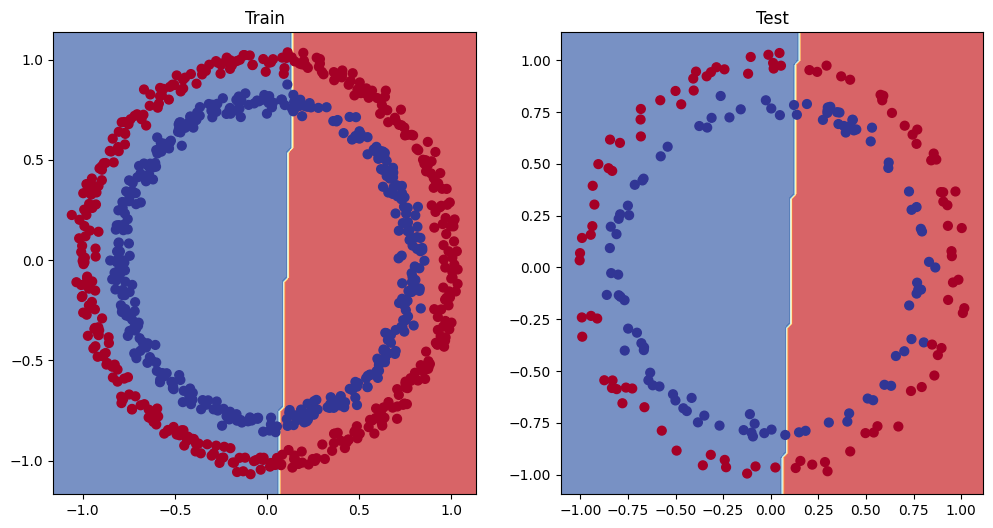

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Model is not working as expected as we did not include non-linearity

We need to combine linearity and non-linearity

In [ ]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [ ]:
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test Loss: 0.6931881904602051, Test Acc: 50.00%
Epoch: 100 | Loss: 0.69115, Acc: 52.88% | Test Loss: 0.6910240054130554, Test Acc: 52.50%
Epoch: 200 | Loss: 0.68977, Acc: 53.37% | Test Loss: 0.6893961429595947, Test Acc: 55.00%
Epoch: 300 | Loss: 0.68795, Acc: 53.00% | Test Loss: 0.6872316598892212, Test Acc: 56.00%
Epoch: 400 | Loss: 0.68517, Acc: 52.75% | Test Loss: 0.684114933013916, Test Acc: 56.50%
Epoch: 500 | Loss: 0.68102, Acc: 52.75% | Test Loss: 0.6794120669364929, Test Acc: 56.50%
Epoch: 600 | Loss: 0.67515, Acc: 54.50% | Test Loss: 0.6728507280349731, Test Acc: 56.00%
Epoch: 700 | Loss: 0.66659, Acc: 58.38% | Test Loss: 0.6632164716720581, Test Acc: 59.00%
Epoch: 800 | Loss: 0.65160, Acc: 64.00% | Test Loss: 0.647568941116333, Test Acc: 67.50%
Epoch: 900 | Loss: 0.62362, Acc: 74.00% | Test Loss: 0.6214525699615479, Test Acc: 79.00%


In [ ]:
y_preds.shape, y_test.shape
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

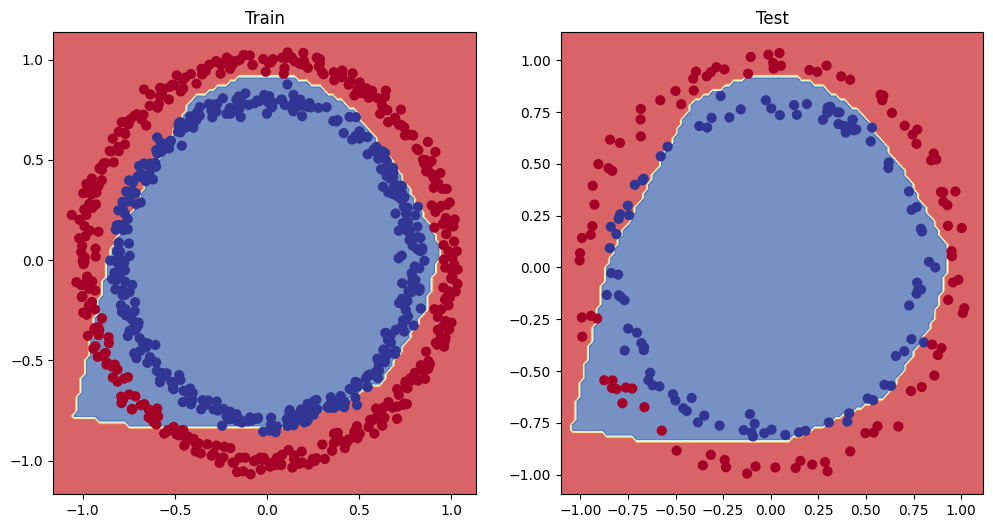

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## Replicating non linear activation functions

In [ ]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [ ]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

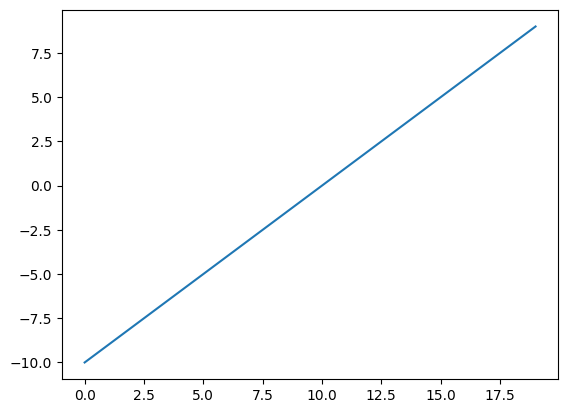

In [ ]:
plt.plot(A);

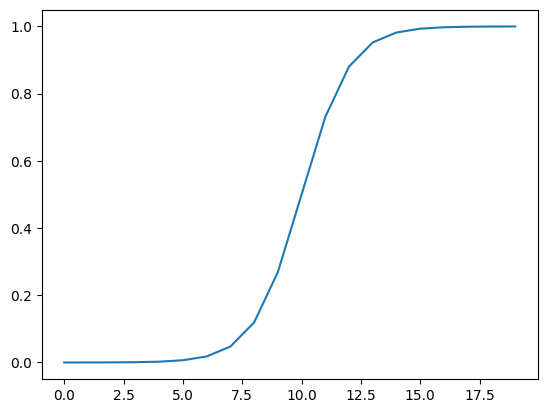

In [ ]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

plt.plot(sigmoid(A));